<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: spec2, pathloss step for fs prism

<span style="color:red"> **Instruments Affected**</span>: NIRSpec 

Tested on CV3 data

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Testing Data Set](#data_ID) <br> [Run the JWST pipeline and assign_wcs validation tests](#pipeline_ID): [FS Full-Frame test](#FULLFRAME), [FS ALLSLITS test](#ALLSLITS), [MOS test](#MOS) <br> [About This Notebook](#about_ID)<br> [Results](#results) <br>

</div>

<a id="imports_ID"></a>
# Imports
The library imports relevant to this notebook are aready taken care of by importing PTT.

* astropy.io for opening fits files
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot.plt to generate plot

NOTE: This notebook assumes that the pipeline version to be tested is already installed and its environment is activated.

To be able to run this notebook you need to install nptt. 

If all goes well you will be able to import PTT.

[Top of Page](#title_ID)

In [1]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
import shutil
data_dir = TemporaryDirectory()

os.chdir(data_dir.name)

In [2]:
import os
if 'CRDS_CACHE_TYPE' in os.environ:
    if os.environ['CRDS_CACHE_TYPE'] == 'local':
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif os.path.isdir(os.environ['CRDS_CACHE_TYPE']):
        os.environ['CRDS_PATH'] = os.environ['CRDS_CACHE_TYPE']
print('CRDS cache location: {}'.format(os.environ['CRDS_PATH']))

CRDS cache location: /grp/crds/cache


In [3]:
import warnings
import psutil
from astropy.io import fits

# Only print a DeprecationWarning the first time it shows up, not every time.
with warnings.catch_warnings():
    warnings.simplefilter("once", category=DeprecationWarning)
    import jwst
    from jwst.pipeline.calwebb_detector1 import Detector1Pipeline
    from jwst.assign_wcs.assign_wcs_step import AssignWcsStep
    from jwst.msaflagopen.msaflagopen_step import MSAFlagOpenStep
    from jwst.extract_2d.extract_2d_step import Extract2dStep
    from jwst.srctype.srctype_step import SourceTypeStep
    from jwst.wavecorr.wavecorr_step import WavecorrStep
    from jwst.flatfield.flat_field_step import FlatFieldStep
    from jwst.pathloss.pathloss_step import PathLossStep
    from jwst import datamodels

# The latest version of NPTT is installed in the requirements text file at:
# /jwst_validation_notebooks/environment.yml

# import NPTT
import nirspec_pipe_testing_tool as nptt

# To get data from Artifactory
from ci_watson.artifactory_helpers import get_bigdata


In [4]:
# Make sure that the version used is the right one

pipeline_version = jwst.__version__
nptt_version = nptt.__version__

print("Using jwst pipeline version: ", pipeline_version)
print("Using NPTT version: ", nptt_version)

Using jwst pipeline version:  1.8.2
Using NPTT version:  2.0.1


<a id="intro_ID"></a>
# Test Description

The NIRSpec team developed an implementation of the pathloss step and compared the output to the pipeline output for this step. We expected machine precision differences (about 10^-7) but due to rounding differences in interpolation methods we relaxed the difference threshold to 10^-6. 

For the test to be considered PASSED, every single slit (for FS data), slitlet (for MOS data) or slice (for IFU data) in the input file has to pass. If there is any failure, the whole test will be considered as FAILED. 

The code for this test for Fixed Slits (FS) can be obtained from: https://github.com/spacetelescope/nirspec_pipe_testing_tool/blob/master/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/pathloss_fs_ps.py. There is a corresponding script for Multi Object Spectroscopy (MOS) and for Integral Field Unit (IFU) data. Each mode has a script for point source (ps) and for uniform source (uni).


Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/pathloss/description.html

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/pathloss


### Results

If the test **PASSED** this means that all slits, slitlets, or slices individually passed the test. However, if ony one individual slit (for FS data), slitlet (for MOS data) or slice (for IFU data) test failed, the whole test will be reported as **FAILED**.


### Calibration WG Requested Algorithm: 

A short description and link to the page: https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Spectral+GWCS+Information 


### Defining Term
Acronymns used un this notebook:

pipeline: calibration pipeline

spec2: spectroscopic calibration pipeline level 2b

PTT: NIRSpec pipeline testing tool (https://github.com/spacetelescope/nirspec_pipe_testing_tool)


[Top of Page](#title_ID)

<a id="pipeline_ID"></a>
# Run the JWST pipeline and pathloss validation tests

The pipeline can be run from the command line in two variants: full or per step.

Tu run the spec2 pipeline in full use the command: 

$ strun jwst.pipeline.Spec2Pipeline jwtest_rate.fits

Tu only run the pathloss step, use the command:

$ strun jwst.pathloss.PathLossStep jwtest_previous_step_output.fits


These options are also callable from a script with the testing environment active. The Python call for running the pipeline in full or by step are:

$\gt$ from jwst.pipeline.calwebb_spec2 import Spec2Pipeline

$\gt$ Spec2Pipeline.call(jwtest_rate.fits)
 
or
 
$\gt$ from jwst.pathloss import PathLossStep
 
$\gt$ PathLossStep.call(jwtest_previous_step_output.fits)


PTT can run the spec2 pipeline either in full or per step, as well as the imaging pipeline in full. In this notebook we will use PTT to run the pipeline and the validation tests. To run PTT, follow the directions in the corresponding repo page.

[Top of Page](#title_ID)

<a id="data_ID"></a>
# Testing Data Set

All testing data is from the CV3 campaign. We chose these files because this is our most complete data set, i.e. all modes and filter-grating combinations.

Data used was for testing was only FS and MOS, since extract_2d is skipped for IFU. Data sets are:
- FS_PRISM_CLEAR


[Top of Page](#title_ID)

In [5]:
testing_data = {'fs_prism_clear':{
                                  'uncal_file_nrs1': 'fs_prism_nrs1_uncal.fits',
                                  'uncal_file_nrs2': 'fs_prism_nrs2_uncal.fits',
                                  'msa_shutter_config': None }
               }



In [6]:
# define function to pull data from Artifactory
def get_artifactory_file(data_set_dict, detector):
    """This function creates a list with all the files needed per detector to run the test.
    Args:
        data_set_dict: dictionary, contains inputs for a specific mode and configuration
        detector: string, either nrs1 or nrs2
    Returns:
        data: list, contains all files needed to run test
    """
    files2obtain = ['uncal_file_nrs1', 'msa_shutter_config']
    data = []
    for file in files2obtain:
        data_file = None
        try: 
            if '_nrs' in file and '2' in detector:
                file = file.replace('_nrs1', '_nrs2')

            data_file = get_bigdata('jwst_validation_notebooks',
                                         'validation_data',
                                         'nirspec_data', 
                                         data_set_dict[file])
        except TypeError:
            data.append(None)
            continue

        data.append(data_file)

    return data

Testing files for detector:  nrs1


Working with uncal_file:  /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpitv6l5wx/fs_prism_nrs1_uncal.fits


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stdatamodels/validate.py:38: ValidationWarning: While validating meta.instrument.fixed_slit the following error occurred:
'FULL' is not one of ['S200A1', 'S200A2', 'S200B1', 'S400A1', 'S1600A1', 'NONE']

Failed validating 'enum' in schema:
    OrderedDict([('title', 'Name of fixed slit aperture used'),
                 ('type', 'string'),
                 ('enum',
                  ['S200A1',
                   'S200A2',
                   'S200B1',
                   'S400A1',
                   'S1600A1',
                   'NONE']),
                 ('fits_keyword', 'FXD_SLIT'),
                 ('blend_table', True)])

On instance:
    'FULL'
  warnings.warn(errmsg, ValidationWarning)


2022-12-04 01:43:45,558 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_nirspec_pars-detector1pipeline_0004.asdf


2022-12-04 01:43:45,581 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-12-04 01:43:45,583 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-12-04 01:43:45,584 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-12-04 01:43:45,585 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-12-04 01:43:45,586 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-12-04 01:43:45,588 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-12-04 01:43:45,589 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-12-04 01:43:45,590 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-12-04 01:43:45,591 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-12-04 01:43:45,592 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-12-04 01:43:45,593 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-12-04 01:43:45,594 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-12-04 01:43:45,595 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-12-04 01:43:45,596 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-12-04 01:43:45,598 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-12-04 01:43:45,599 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-12-04 01:43:45,600 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-12-04 01:43:45,793 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpitv6l5wx/fs_prism_nrs1_uncal.fits',).


2022-12-04 01:43:45,803 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outp

2022-12-04 01:43:45,999 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'fs_prism_nrs1_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-12-04 01:43:46,007 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_dark_0086.fits'.


2022-12-04 01:43:46,010 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_gain_0019.fits'.


2022-12-04 01:43:46,011 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_linearity_0018.fits'.


2022-12-04 01:43:46,013 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_mask_0010.fits'.


2022-12-04 01:43:46,015 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-12-04 01:43:46,015 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0018.fits'.


2022-12-04 01:43:46,017 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_refpix_0022.fits'.


2022-12-04 01:43:46,018 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-12-04 01:43:46,019 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2022-12-04 01:43:46,019 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_saturation_0020.fits'.


2022-12-04 01:43:46,021 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_superbias_0113.fits'.


2022-12-04 01:43:46,023 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-12-04 01:43:46,023 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-12-04 01:43:46,024 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-12-04 01:43:46,475 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 4, 3200, 2048) from fs_prism_nrs1_uncal.fits>,).


2022-12-04 01:43:46,476 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpitv6l5wx'}


2022-12-04 01:43:46,619 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2022-12-04 01:43:46,620 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-12-04 01:43:46,623 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-12-04 01:43:46,810 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 4, 3200, 2048) from fs_prism_nrs1_uncal.fits>,).


2022-12-04 01:43:46,811 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpitv6l5wx'}


2022-12-04 01:43:46,836 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_nirspec_mask_0010.fits


2022-12-04 01:43:47,948 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-12-04 01:43:48,140 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 4, 3200, 2048) from fs_prism_nrs1_uncal.fits>,).


2022-12-04 01:43:48,142 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpitv6l5wx', 'n_pix_grow_sat': 1}


2022-12-04 01:43:48,167 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_nirspec_saturation_0020.fits


2022-12-04 01:43:50,330 - stpipe.Detector1Pipeline.saturation - INFO - Detected 49730 saturated pixels


2022-12-04 01:43:50,366 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-12-04 01:43:50,394 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-12-04 01:43:50,595 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 4, 3200, 2048) from fs_prism_nrs1_uncal.fits>,).


2022-12-04 01:43:50,597 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpitv6l5wx'}


2022-12-04 01:43:50,597 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-12-04 01:43:50,600 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-12-04 01:43:50,783 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 4, 3200, 2048) from fs_prism_nrs1_uncal.fits>,).


2022-12-04 01:43:50,784 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpitv6l5wx'}


2022-12-04 01:43:50,813 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /grp/crds/cache/references/jwst/jwst_nirspec_superbias_0113.fits


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stdatamodels/validate.py:38: ValidationWarning: While validating meta.exposure.readpatt the following error occurred:
'ALLIRS2' is not one of ['ACQ1', 'ACQ2', 'BRIGHT1', 'BRIGHT2', 'DEEP2', 'DEEP8', 'FAST', 'FASTGRPAVG', 'FASTGRPAVG8', 'FASTGRPAVG16', 'FASTGRPAVG32', 'FASTGRPAVG64', 'FASTR1', 'FASTR100', 'FGS', 'FGS60', 'FGS8370', 'FGS840', 'FGSRAPID', 'FINEGUIDE', 'ID', 'MEDIUM2', 'MEDIUM8', 'NIS', 'NISRAPID', 'NRS', 'NRSIRS2', 'NRSN16R4', 'NRSN32R8', 'NRSN8R2', 'NRSRAPID', 'NRSIRS2RAPID', 'NRSRAPIDD1', 'NRSRAPIDD2', 'NRSRAPIDD6', 'NRSSLOW', 'RAPID', 'SHALLOW2', 'SHALLOW4', 'SLOW', 'SLOWR1', 'TRACK', 'ANY', 'N/A']

Failed validating 'enum' in schema:
    OrderedDict([('title', 'Readout pattern'),
                 ('type', 'string'),
                 ('enum',
                  ['ACQ1',
                   'ACQ2',
                   'B

2022-12-04 01:43:55,728 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2022-12-04 01:43:55,930 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 4, 3200, 2048) from fs_prism_nrs1_uncal.fits>,).


2022-12-04 01:43:55,932 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpitv6l5wx', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-12-04 01:43:55,962 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /grp/crds/cache/references/jwst/jwst_nirspec_refpix_0022.fits


2022-12-04 01:43:59,135 - stpipe.Detector1Pipeline.refpix - INFO - Working on integration 1


2022-12-04 01:44:13,213 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-12-04 01:44:13,588 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 4, 3200, 2048) from fs_prism_nrs1_uncal.fits>,).


2022-12-04 01:44:13,590 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpitv6l5wx'}


2022-12-04 01:44:13,617 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_nirspec_linearity_0018.fits


2022-12-04 01:44:18,415 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-12-04 01:44:18,633 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 4, 3200, 2048) from fs_prism_nrs1_uncal.fits>,).


2022-12-04 01:44:18,635 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpitv6l5wx', 'dark_output': None}


2022-12-04 01:44:18,719 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_nirspec_dark_0086.fits


2022-12-04 01:45:01,613 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=4, nframes=1, groupgap=0


2022-12-04 01:45:01,614 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=65, nframes=1, groupgap=0


2022-12-04 01:45:02,213 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-12-04 01:45:02,423 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 4, 3200, 2048) from fs_prism_nrs1_uncal.fits>,).


2022-12-04 01:45:02,425 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpitv6l5wx', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0, 'min_sat_area': 1.0, 'min_jump_area': 5.0, 'expand_factor': 2.0, 'use_ellipses': False, 'sat_required_snowball': True, 'expand_large_events': False}


2022-12-04 01:45:02,456 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-12-04 01:45:02,498 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0019.fits


2022-12-04 01:45:03,178 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0018.fits


2022-12-04 01:45:04,063 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-12-04 01:45:04,107 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/twopoint_difference.py:154: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)
2022-12-04 01:45:05,571 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-12-04 01:45:06,184 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 2.12054 sec


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/jump.py:302: RuntimeWarning: invalid value encountered in divide
  data /= gain_2d
/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/jump.py:303: RuntimeWarning: invalid value encountered in divide
  err /= gain_2d
/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/jump.py:304: RuntimeWarning: invalid value encountered in divide
  readnoise_2d /= gain_2d
2022-12-04 01:45:06,238 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 3.781493


2022-12-04 01:45:06,244 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-12-04 01:45:06,394 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 4, 3200, 2048) from fs_prism_nrs1_uncal.fits>,).


2022-12-04 01:45:06,396 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpitv6l5wx', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-12-04 01:45:06,480 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0018.fits


2022-12-04 01:45:06,481 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0019.fits


2022-12-04 01:45:06,596 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-12-04 01:45:06,597 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


2022-12-04 01:45:20,686 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 4


2022-12-04 01:45:20,687 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 1


2022-12-04 01:45:20,876 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-12-04 01:45:21,025 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(2048, 2048) from fs_prism_nrs1_uncal.fits>,).


2022-12-04 01:45:21,027 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpitv6l5wx'}


2022-12-04 01:45:21,099 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-12-04 01:45:21,099 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-12-04 01:45:21,104 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-12-04 01:45:21,221 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from fs_prism_nrs1_uncal.fits>,).


2022-12-04 01:45:21,223 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpitv6l5wx'}


2022-12-04 01:45:21,296 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-12-04 01:45:21,297 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-12-04 01:45:21,302 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-12-04 01:45:21,302 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-12-04 01:45:21,303 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-04 01:45:21,303 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-12-04 01:45:21,313 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-12-04 01:45:21,429 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from fs_prism_nrs1_uncal.fits>,).


2022-12-04 01:45:21,430 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.1, 'sip_degree': None, 'sip_max_inv_pix_error': 0.1, 'sip_inv_degree': None, 'sip_npoints': 12, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-12-04 01:45:21,619 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.0332140289247036 deg


2022-12-04 01:45:21,619 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3367482721805573 deg


2022-12-04 01:45:21,620 - stpipe.AssignWcsStep - INFO - theta_y correction: -1.0907214098475986e-05 deg


2022-12-04 01:45:21,621 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg


2022-12-04 01:45:22,029 - stpipe.AssignWcsStep - INFO - Removing slit S200B1 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-12-04 01:45:22,030 - stpipe.AssignWcsStep - INFO - Slits projected on detector NRS1: ['S200A1', 'S200A2', 'S400A1', 'S1600A1']


2022-12-04 01:45:22,031 - stpipe.AssignWcsStep - INFO - Computing WCS for 4 open slitlets


2022-12-04 01:45:22,072 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.0332140289247036 deg


2022-12-04 01:45:22,073 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3367482721805573 deg


2022-12-04 01:45:22,074 - stpipe.AssignWcsStep - INFO - theta_y correction: -1.0907214098475986e-05 deg


2022-12-04 01:45:22,075 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg


2022-12-04 01:45:22,092 - stpipe.AssignWcsStep - INFO - SPORDER= 0, wrange=[6e-07, 5.3e-06]


2022-12-04 01:45:22,260 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 1


2022-12-04 01:45:22,261 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 2


2022-12-04 01:45:22,262 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 3


2022-12-04 01:45:22,262 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 4


2022-12-04 01:45:22,262 - stpipe.AssignWcsStep - INFO - There are 4 open slits in quadrant 5


2022-12-04 01:45:22,478 - stpipe.AssignWcsStep - INFO - Created a NIRSPEC nrs_fixedslit pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_nirspec_wavelengthrange_0004.asdf', 'camera': '/grp/crds/cache/references/jwst/jwst_nirspec_camera_0004.asdf', 'collimator': '/grp/crds/cache/references/jwst/jwst_nirspec_collimator_0004.asdf', 'disperser': '/grp/crds/cache/references/jwst/jwst_nirspec_disperser_0034.asdf', 'fore': '/grp/crds/cache/references/jwst/jwst_nirspec_fore_0028.asdf', 'fpa': '/grp/crds/cache/references/jwst/jwst_nirspec_fpa_0005.asdf', 'msa': '/grp/crds/cache/references/jwst/jwst_nirspec_msa_0005.asdf', 'ote': '/grp/crds/cache/references/jwst/jwst_nirspec_ote_0005.asdf', 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-12-04 01:45:22,723 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-12-04 01:45:22,739 - stpipe.AssignWcsStep - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-04 01:45:22,739 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2022-12-04 01:45:22,749 - stpipe.Extract2dStep - INFO - Extract2dStep instance created.


2022-12-04 01:45:22,896 - stpipe.Extract2dStep - INFO - Step Extract2dStep running with args (<ImageModel(2048, 2048) from fs_prism_nrs1_uncal.fits>,).


2022-12-04 01:45:22,897 - stpipe.Extract2dStep - INFO - Step Extract2dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'slit_name': None, 'extract_orders': None, 'grism_objects': None, 'tsgrism_extract_height': None, 'wfss_extract_half_height': 5, 'wfss_mmag_extract': None, 'wfss_nbright': 1000}


2022-12-04 01:45:22,915 - stpipe.Extract2dStep - INFO - EXP_TYPE is NRS_FIXEDSLIT


2022-12-04 01:45:23,128 - stpipe.Extract2dStep - INFO - Name of subarray extracted: S200A1


2022-12-04 01:45:23,129 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1083 1518


2022-12-04 01:45:23,129 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1057 1096


2022-12-04 01:45:23,340 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2022-12-04 01:45:23,350 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.191685737 -45.682908511 156.190837415 -45.682092120 156.190771015 -45.682126390 156.191619323 -45.682942792


2022-12-04 01:45:23,352 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.191685737 -45.682908511 156.190837415 -45.682092120 156.190771015 -45.682126390 156.191619323 -45.682942792


2022-12-04 01:45:23,543 - stpipe.Extract2dStep - INFO - Name of subarray extracted: S200A2


2022-12-04 01:45:23,544 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 892 1328


2022-12-04 01:45:23,544 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1021 1060


2022-12-04 01:45:23,781 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2022-12-04 01:45:23,790 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.184519149 -45.685298792 156.183675453 -45.684484578 156.183609578 -45.684518640 156.184453260 -45.685332865


2022-12-04 01:45:23,792 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.184519149 -45.685298792 156.183675453 -45.684484578 156.183609578 -45.684518640 156.184453260 -45.685332865


2022-12-04 01:45:23,971 - stpipe.Extract2dStep - INFO - Name of subarray extracted: S400A1


2022-12-04 01:45:23,972 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1025 1460


2022-12-04 01:45:23,973 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 980 1024


2022-12-04 01:45:24,321 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2022-12-04 01:45:24,330 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.187759056 -45.682331806 156.186793281 -45.681401531 156.186663358 -45.681468621 156.187629101 -45.682398919


2022-12-04 01:45:24,332 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.187759056 -45.682331806 156.186793281 -45.681401531 156.186663358 -45.681468621 156.187629101 -45.682398919


2022-12-04 01:45:24,513 - stpipe.Extract2dStep - INFO - Name of subarray extracted: S1600A1


2022-12-04 01:45:24,514 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1056 1488


2022-12-04 01:45:24,515 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 960 982


2022-12-04 01:45:24,705 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2022-12-04 01:45:24,714 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.187720636 -45.680802803 156.187307671 -45.680405209 156.186792650 -45.680671077 156.187205560 -45.681068709


2022-12-04 01:45:24,716 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.187720636 -45.680802803 156.187307671 -45.680405209 156.186792650 -45.680671077 156.187205560 -45.681068709


2022-12-04 01:45:24,911 - stpipe.Extract2dStep - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-04 01:45:24,912 - stpipe.Extract2dStep - INFO - Step Extract2dStep done


2022-12-04 01:45:25,305 - stpipe.SourceTypeStep - INFO - SourceTypeStep instance created.


2022-12-04 01:45:25,489 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep running with args (<MultiSlitModel from fs_prism_nrs1_uncal.fits>,).


2022-12-04 01:45:25,490 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'source_type': None}


2022-12-04 01:45:25,498 - stpipe.SourceTypeStep - INFO - Input EXP_TYPE is NRS_FIXEDSLIT


2022-12-04 01:45:25,499 - stpipe.SourceTypeStep - INFO - Input SRCTYAPT = UNKNOWN


2022-12-04 01:45:25,499 - stpipe.SourceTypeStep - INFO - Input source type is unknown; setting default SRCTYPE = POINT


2022-12-04 01:45:25,506 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep done


2022-12-04 01:45:25,523 - stpipe.WavecorrStep - INFO - WavecorrStep instance created.


2022-12-04 01:45:25,671 - stpipe.WavecorrStep - INFO - Step WavecorrStep running with args (<MultiSlitModel from fs_prism_nrs1_uncal.fits>,).


2022-12-04 01:45:25,673 - stpipe.WavecorrStep - INFO - Step WavecorrStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-04 01:45:25,697 - stpipe.WavecorrStep - INFO - Using WAVECORR reference file /grp/crds/cache/references/jwst/jwst_nirspec_wavecorr_0003.asdf


2022-12-04 01:45:26,396 - stpipe.WavecorrStep - WARNING - Primary slit name not found in input


2022-12-04 01:45:26,397 - stpipe.WavecorrStep - WARNING - Skipping wavecorr correction


2022-12-04 01:45:26,403 - stpipe.WavecorrStep - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-04 01:45:26,403 - stpipe.WavecorrStep - INFO - Step WavecorrStep done


2022-12-04 01:45:26,419 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.


2022-12-04 01:45:26,585 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args (<MultiSlitModel from fs_prism_nrs1_uncal.fits>,).


2022-12-04 01:45:26,587 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-12-04 01:45:35,497 - stpipe.FlatFieldStep - INFO - Working on slit S200A1


2022-12-04 01:45:39,289 - stpipe.FlatFieldStep - INFO - Working on slit S200A2


2022-12-04 01:45:43,130 - stpipe.FlatFieldStep - INFO - Working on slit S400A1


2022-12-04 01:45:47,419 - stpipe.FlatFieldStep - INFO - Working on slit S1600A1


2022-12-04 01:45:49,424 - stpipe.FlatFieldStep - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-04 01:45:49,425 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep done


2022-12-04 01:45:49,441 - stpipe.PathLossStep - INFO - PathLossStep instance created.


2022-12-04 01:45:49,617 - stpipe.PathLossStep - INFO - Step PathLossStep running with args (<MultiSlitModel from fs_prism_nrs1_uncal.fits>,).


2022-12-04 01:45:49,619 - stpipe.PathLossStep - INFO - Step PathLossStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-12-04 01:45:49,647 - stpipe.PathLossStep - INFO - Using PATHLOSS reference file /grp/crds/cache/references/jwst/jwst_nirspec_pathloss_0001.fits


2022-12-04 01:45:49,748 - stpipe.PathLossStep - INFO - Input exposure type is NRS_FIXEDSLIT


2022-12-04 01:45:50,467 - stpipe.PathLossStep - INFO - Working on slit S200A1


2022-12-04 01:45:50,467 - stpipe.PathLossStep - INFO - Using aperture S200A1


2022-12-04 01:45:50,496 - stpipe.PathLossStep - INFO - Working on slit S200A2


2022-12-04 01:45:50,497 - stpipe.PathLossStep - INFO - Using aperture S200A2


2022-12-04 01:45:50,525 - stpipe.PathLossStep - INFO - Working on slit S400A1


2022-12-04 01:45:50,526 - stpipe.PathLossStep - WARNING - Cannot find matching pathloss model for S400A1


2022-12-04 01:45:50,527 - stpipe.PathLossStep - WARNING - Skipping pathloss correction for this slit


2022-12-04 01:45:50,527 - stpipe.PathLossStep - WARNING - No correction provided for slit 2. Skipping


2022-12-04 01:45:50,527 - stpipe.PathLossStep - INFO - Working on slit S1600A1


2022-12-04 01:45:50,528 - stpipe.PathLossStep - INFO - Using aperture S1600A1


2022-12-04 01:45:50,560 - stpipe.PathLossStep - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-04 01:45:50,561 - stpipe.PathLossStep - INFO - Step PathLossStep done


Running test for FS...
Checking if files exist and obtaining datamodels. This takes a few minutes...
from datamodel  -->     Detector: NRS1   Grating: PRISM   Filter: CLEAR   Lamp: LINE4   EXP_TYPE: NRS_FIXEDSLIT
Now looping through the slits. This may take a while... 
Looping through the wavelengths... 

Working with slitlet  S200A1
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Retrieved point source extension
Using reference file: https://jwst-crds.stsci.edu/unchecked_get/references/jwst/jwst_nirspec_pathloss_0001.fits


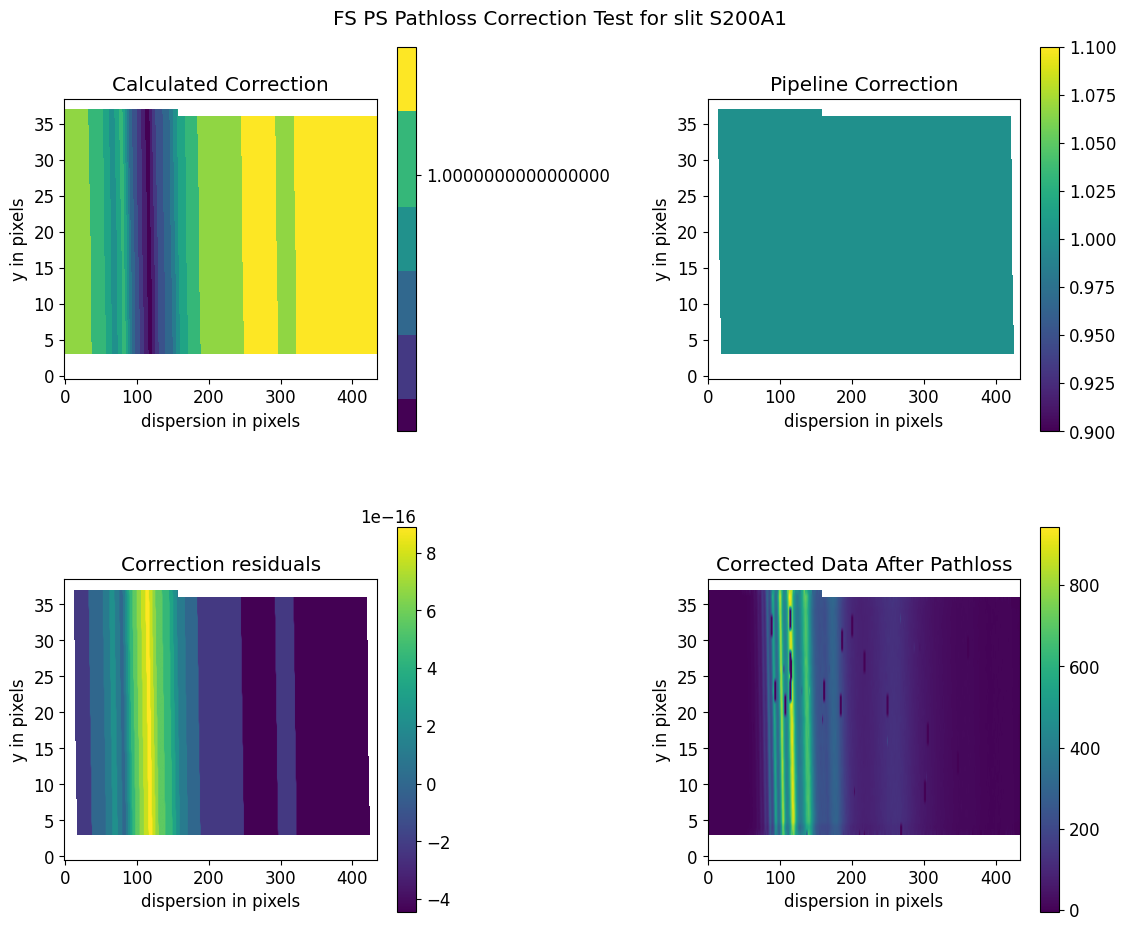

Calculating statistics... 

   Absolute Difference  :   mean = -1.096e-16    median = -2.220e-16    stdev = 3.665e-16
    Maximum   AbsoluteDifference = 8.882e-16
    Minimum   AbsoluteDifference = -4.441e-16
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED


Working with slitlet  S200A2
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Retrieved point source extension
Using reference file: https://jwst-crds.stsci.edu/unchecked_get/references/jwst/jwst_nirspec_pathloss_0001.fits


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/pathloss_fs_ps.py:304: ResourceWarning: unclosed file <_io.BufferedReader name='/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/.astropy/cache/download/url/aa0c667e23a747249d9442a76121955c/contents'>
  hdul = fits.open(reffile2use)


<Figure size 640x480 with 0 Axes>

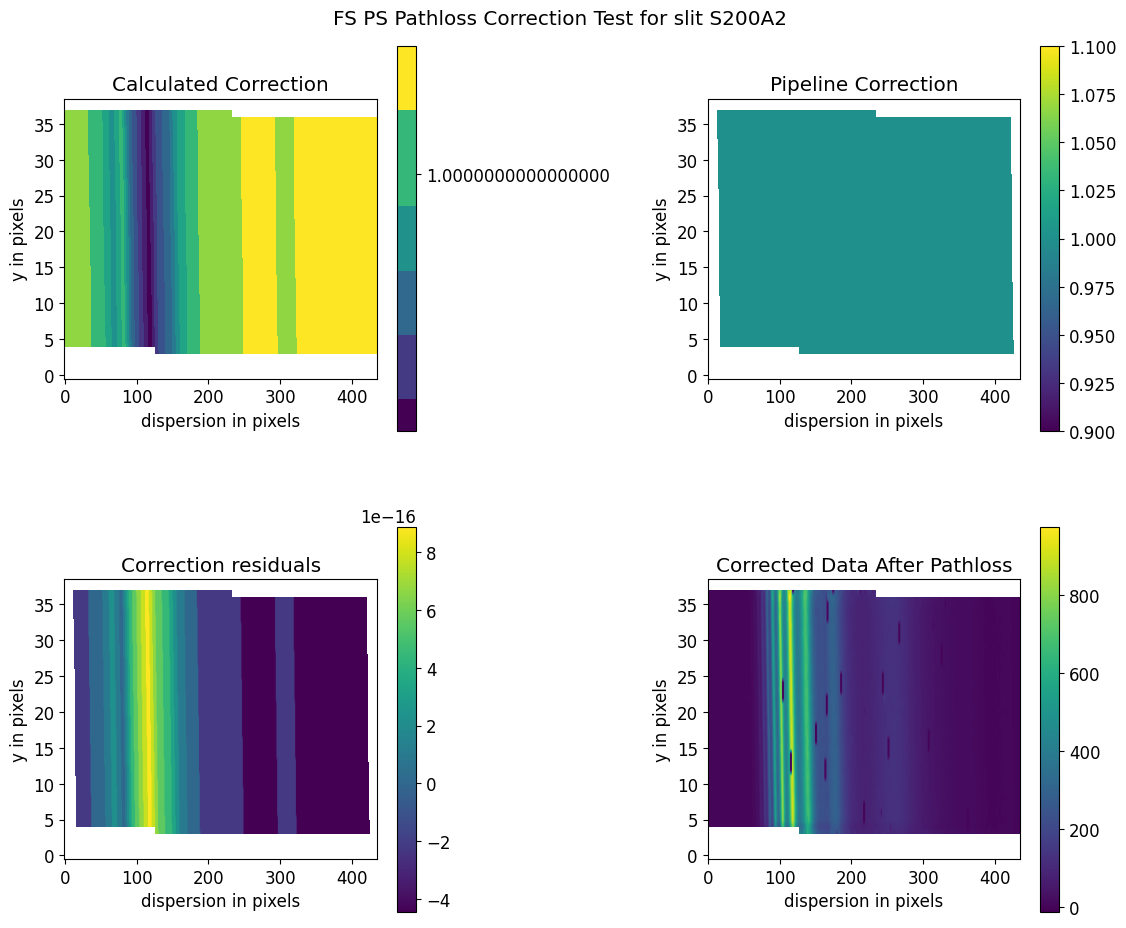

Calculating statistics... 

   Absolute Difference  :   mean = -1.122e-16    median = -2.220e-16    stdev = 3.646e-16
    Maximum   AbsoluteDifference = 8.882e-16
    Minimum   AbsoluteDifference = -4.441e-16
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED


Working with slitlet  S400A1
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Unable to retrieve extension.
Using reference file: https://jwst-crds.stsci.edu/unchecked_get/references/jwst/jwst_nirspec_pathloss_0001.fits
Pipeline pathloss correction in datamodel is empty. Skipping testing this slit.

Working with slitlet  S1600A1
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Retrieved point source 

<Figure size 640x480 with 0 Axes>

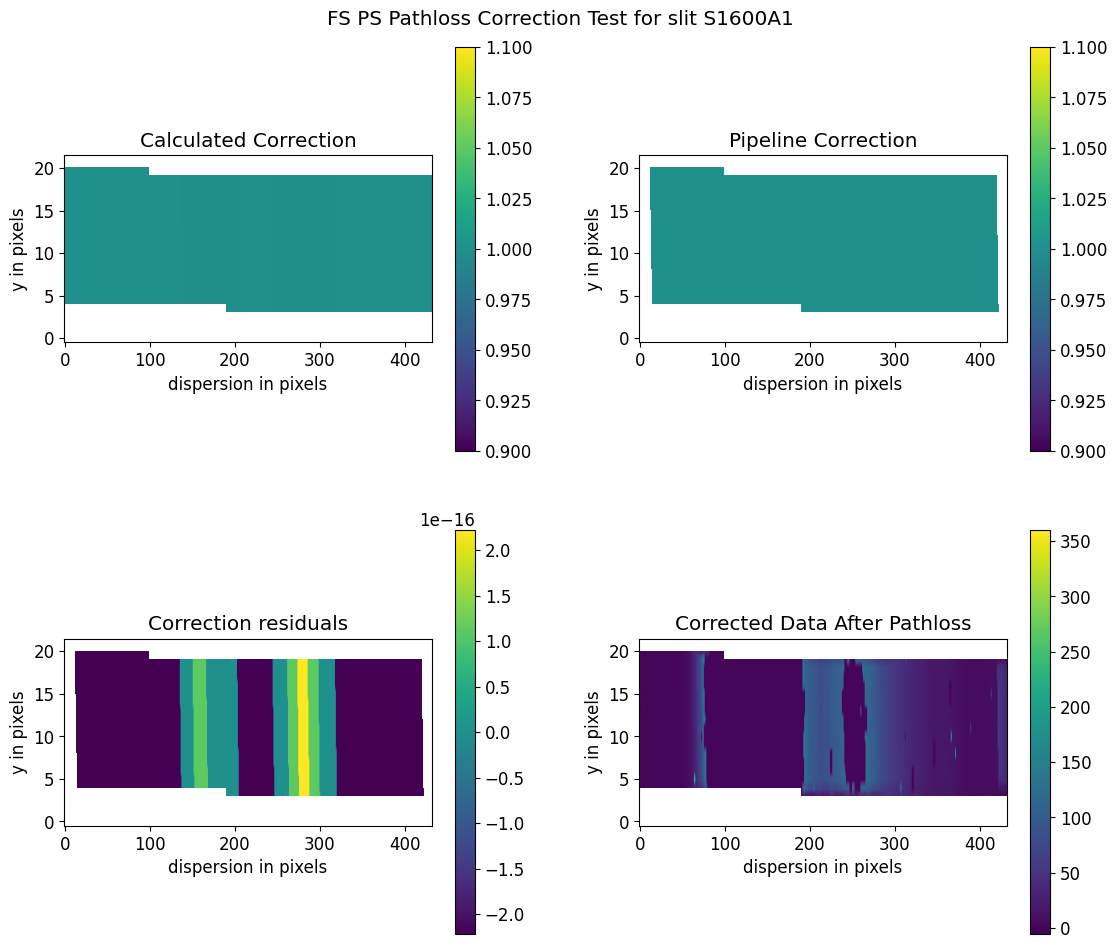

Calculating statistics... 

   Absolute Difference  :   mean = -1.288e-16    median = -2.220e-16    stdev = 1.365e-16
    Maximum   AbsoluteDifference = 2.220e-16
    Minimum   AbsoluteDifference = -2.220e-16
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED


 *** Final pathloss test result reported as PASSED *** 

('* Script FS_PS.py took ', '2.497146713733673 minutes to finish.')
Did pathloss validation test passed?  All slits PASSED path_loss test. 


Testing files for detector:  nrs2


Working with uncal_file:  /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpitv6l5wx/fs_prism_nrs2_uncal.fits


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/io/fits/header.py:534: ResourceWarning: unclosed file <_io.BufferedReader name='/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/.astropy/cache/download/url/aa0c667e23a747249d9442a76121955c/contents'>
  header._keyword_indices[keyword].append(idx)
/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stdatamodels/validate.py:38: ValidationWarning: While validating meta.instrument.fixed_slit the following error occurred:
'FULL' is not one of ['S200A1', 'S200A2', 'S200B1', 'S400A1', 'S1600A1', 'NONE']

Failed validating 'enum' in schema:
    OrderedDict([('title', 'Name of fixed slit aperture used'),
                 ('type', 'string'),
                 ('enum',
                  ['S200A1',
  

2022-12-04 01:48:21,230 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_nirspec_pars-detector1pipeline_0004.asdf


2022-12-04 01:48:21,295 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-12-04 01:48:21,297 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-12-04 01:48:21,298 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-12-04 01:48:21,299 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-12-04 01:48:21,300 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-12-04 01:48:21,301 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-12-04 01:48:21,303 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-12-04 01:48:21,304 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-12-04 01:48:21,305 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-12-04 01:48:21,306 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-12-04 01:48:21,307 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-12-04 01:48:21,308 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-12-04 01:48:21,309 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-12-04 01:48:21,310 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-12-04 01:48:21,312 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-12-04 01:48:21,313 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-12-04 01:48:21,314 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-12-04 01:48:21,752 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpitv6l5wx/fs_prism_nrs2_uncal.fits',).


2022-12-04 01:48:21,764 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outp

2022-12-04 01:48:21,949 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'fs_prism_nrs2_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-12-04 01:48:21,959 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_dark_0087.fits'.


2022-12-04 01:48:21,961 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_gain_0018.fits'.


2022-12-04 01:48:21,962 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_linearity_0021.fits'.


2022-12-04 01:48:21,963 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_mask_0011.fits'.


2022-12-04 01:48:21,965 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-12-04 01:48:21,965 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0017.fits'.


2022-12-04 01:48:21,967 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_refpix_0020.fits'.


2022-12-04 01:48:21,969 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-12-04 01:48:21,969 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2022-12-04 01:48:21,969 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_saturation_0021.fits'.


2022-12-04 01:48:21,972 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_superbias_0114.fits'.


2022-12-04 01:48:21,974 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-12-04 01:48:21,975 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-12-04 01:48:21,975 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-12-04 01:48:22,404 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 4, 3200, 2048) from fs_prism_nrs2_uncal.fits>,).


2022-12-04 01:48:22,405 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpitv6l5wx'}


2022-12-04 01:48:22,512 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2022-12-04 01:48:22,513 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-12-04 01:48:22,516 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-12-04 01:48:22,697 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 4, 3200, 2048) from fs_prism_nrs2_uncal.fits>,).


2022-12-04 01:48:22,699 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpitv6l5wx'}


2022-12-04 01:48:22,721 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_nirspec_mask_0011.fits


2022-12-04 01:48:23,510 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-12-04 01:48:23,699 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 4, 3200, 2048) from fs_prism_nrs2_uncal.fits>,).


2022-12-04 01:48:23,701 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpitv6l5wx', 'n_pix_grow_sat': 1}


2022-12-04 01:48:23,726 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_nirspec_saturation_0021.fits


2022-12-04 01:48:25,363 - stpipe.Detector1Pipeline.saturation - INFO - Detected 40672 saturated pixels


2022-12-04 01:48:25,395 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-12-04 01:48:25,418 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-12-04 01:48:25,599 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 4, 3200, 2048) from fs_prism_nrs2_uncal.fits>,).


2022-12-04 01:48:25,602 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpitv6l5wx'}


2022-12-04 01:48:25,602 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-12-04 01:48:25,605 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-12-04 01:48:25,791 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 4, 3200, 2048) from fs_prism_nrs2_uncal.fits>,).


2022-12-04 01:48:25,793 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpitv6l5wx'}


2022-12-04 01:48:25,821 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /grp/crds/cache/references/jwst/jwst_nirspec_superbias_0114.fits


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stdatamodels/validate.py:38: ValidationWarning: While validating meta.exposure.readpatt the following error occurred:
'ALLIRS2' is not one of ['ACQ1', 'ACQ2', 'BRIGHT1', 'BRIGHT2', 'DEEP2', 'DEEP8', 'FAST', 'FASTGRPAVG', 'FASTGRPAVG8', 'FASTGRPAVG16', 'FASTGRPAVG32', 'FASTGRPAVG64', 'FASTR1', 'FASTR100', 'FGS', 'FGS60', 'FGS8370', 'FGS840', 'FGSRAPID', 'FINEGUIDE', 'ID', 'MEDIUM2', 'MEDIUM8', 'NIS', 'NISRAPID', 'NRS', 'NRSIRS2', 'NRSN16R4', 'NRSN32R8', 'NRSN8R2', 'NRSRAPID', 'NRSIRS2RAPID', 'NRSRAPIDD1', 'NRSRAPIDD2', 'NRSRAPIDD6', 'NRSSLOW', 'RAPID', 'SHALLOW2', 'SHALLOW4', 'SLOW', 'SLOWR1', 'TRACK', 'ANY', 'N/A']

Failed validating 'enum' in schema:
    OrderedDict([('title', 'Readout pattern'),
                 ('type', 'string'),
                 ('enum',
                  ['ACQ1',
                   'ACQ2',
                   'B

2022-12-04 01:48:29,861 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2022-12-04 01:48:30,048 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 4, 3200, 2048) from fs_prism_nrs2_uncal.fits>,).


2022-12-04 01:48:30,049 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpitv6l5wx', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-12-04 01:48:30,073 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /grp/crds/cache/references/jwst/jwst_nirspec_refpix_0020.fits


2022-12-04 01:48:33,017 - stpipe.Detector1Pipeline.refpix - INFO - Working on integration 1


2022-12-04 01:48:47,225 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-12-04 01:48:47,496 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 4, 3200, 2048) from fs_prism_nrs2_uncal.fits>,).


2022-12-04 01:48:47,498 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpitv6l5wx'}


2022-12-04 01:48:47,525 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_nirspec_linearity_0021.fits


2022-12-04 01:48:52,031 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-12-04 01:48:52,235 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 4, 3200, 2048) from fs_prism_nrs2_uncal.fits>,).


2022-12-04 01:48:52,237 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpitv6l5wx', 'dark_output': None}


2022-12-04 01:48:52,319 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_nirspec_dark_0087.fits


2022-12-04 01:49:29,222 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=4, nframes=1, groupgap=0


2022-12-04 01:49:29,222 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=65, nframes=1, groupgap=0


2022-12-04 01:49:29,735 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-12-04 01:49:29,935 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 4, 3200, 2048) from fs_prism_nrs2_uncal.fits>,).


2022-12-04 01:49:29,937 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpitv6l5wx', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0, 'min_sat_area': 1.0, 'min_jump_area': 5.0, 'expand_factor': 2.0, 'use_ellipses': False, 'sat_required_snowball': True, 'expand_large_events': False}


2022-12-04 01:49:29,969 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-12-04 01:49:30,014 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0018.fits


2022-12-04 01:49:30,844 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0017.fits


2022-12-04 01:49:32,322 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-12-04 01:49:32,366 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/twopoint_difference.py:154: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)
2022-12-04 01:49:33,913 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-12-04 01:49:34,299 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 1.97574 sec


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/jump.py:302: RuntimeWarning: invalid value encountered in divide
  data /= gain_2d
/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/jump.py:303: RuntimeWarning: invalid value encountered in divide
  err /= gain_2d
/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/jump.py:304: RuntimeWarning: invalid value encountered in divide
  readnoise_2d /= gain_2d
2022-12-04 01:49:34,350 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 4.380900


2022-12-04 01:49:34,355 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-12-04 01:49:34,539 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 4, 3200, 2048) from fs_prism_nrs2_uncal.fits>,).


2022-12-04 01:49:34,540 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpitv6l5wx', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-12-04 01:49:34,622 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0017.fits


2022-12-04 01:49:34,623 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0018.fits


2022-12-04 01:49:34,739 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-12-04 01:49:34,740 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


2022-12-04 01:49:48,464 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 4


2022-12-04 01:49:48,465 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 1


2022-12-04 01:49:48,660 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-12-04 01:49:48,843 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(2048, 2048) from fs_prism_nrs2_uncal.fits>,).


2022-12-04 01:49:48,845 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpitv6l5wx'}


2022-12-04 01:49:48,915 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-12-04 01:49:48,916 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-12-04 01:49:48,920 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-12-04 01:49:49,101 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from fs_prism_nrs2_uncal.fits>,).


2022-12-04 01:49:49,103 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpitv6l5wx'}


2022-12-04 01:49:49,176 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-12-04 01:49:49,177 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-12-04 01:49:49,181 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-12-04 01:49:49,182 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-12-04 01:49:49,182 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-04 01:49:49,182 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-12-04 01:49:49,192 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-12-04 01:49:49,376 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from fs_prism_nrs2_uncal.fits>,).


2022-12-04 01:49:49,378 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.1, 'sip_degree': None, 'sip_max_inv_pix_error': 0.1, 'sip_inv_degree': None, 'sip_npoints': 12, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-12-04 01:49:49,580 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.0332140289247036 deg


2022-12-04 01:49:49,581 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3367482721805573 deg


2022-12-04 01:49:49,582 - stpipe.AssignWcsStep - INFO - theta_y correction: -1.0907214098475986e-05 deg


2022-12-04 01:49:49,583 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg


2022-12-04 01:49:49,864 - stpipe.AssignWcsStep - INFO - Removing slit S200A1 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-12-04 01:49:49,904 - stpipe.AssignWcsStep - INFO - Removing slit S200A2 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-12-04 01:49:49,949 - stpipe.AssignWcsStep - INFO - Removing slit S400A1 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-12-04 01:49:49,994 - stpipe.AssignWcsStep - INFO - Removing slit S1600A1 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-12-04 01:49:50,035 - stpipe.AssignWcsStep - INFO - Slits projected on detector NRS2: ['S200B1']


2022-12-04 01:49:50,036 - stpipe.AssignWcsStep - INFO - Computing WCS for 1 open slitlets


2022-12-04 01:49:50,076 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.0332140289247036 deg


2022-12-04 01:49:50,077 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3367482721805573 deg


2022-12-04 01:49:50,078 - stpipe.AssignWcsStep - INFO - theta_y correction: -1.0907214098475986e-05 deg


2022-12-04 01:49:50,079 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg


2022-12-04 01:49:50,094 - stpipe.AssignWcsStep - INFO - SPORDER= 0, wrange=[6e-07, 5.3e-06]


2022-12-04 01:49:50,256 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 1


2022-12-04 01:49:50,257 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 2


2022-12-04 01:49:50,258 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 3


2022-12-04 01:49:50,258 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 4


2022-12-04 01:49:50,258 - stpipe.AssignWcsStep - INFO - There are 1 open slits in quadrant 5


2022-12-04 01:49:50,454 - stpipe.AssignWcsStep - INFO - Created a NIRSPEC nrs_fixedslit pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_nirspec_wavelengthrange_0004.asdf', 'camera': '/grp/crds/cache/references/jwst/jwst_nirspec_camera_0004.asdf', 'collimator': '/grp/crds/cache/references/jwst/jwst_nirspec_collimator_0004.asdf', 'disperser': '/grp/crds/cache/references/jwst/jwst_nirspec_disperser_0034.asdf', 'fore': '/grp/crds/cache/references/jwst/jwst_nirspec_fore_0028.asdf', 'fpa': '/grp/crds/cache/references/jwst/jwst_nirspec_fpa_0005.asdf', 'msa': '/grp/crds/cache/references/jwst/jwst_nirspec_msa_0005.asdf', 'ote': '/grp/crds/cache/references/jwst/jwst_nirspec_ote_0005.asdf', 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-12-04 01:49:50,647 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-12-04 01:49:50,661 - stpipe.AssignWcsStep - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-04 01:49:50,662 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2022-12-04 01:49:50,672 - stpipe.Extract2dStep - INFO - Extract2dStep instance created.


2022-12-04 01:49:50,896 - stpipe.Extract2dStep - INFO - Step Extract2dStep running with args (<ImageModel(2048, 2048) from fs_prism_nrs2_uncal.fits>,).


2022-12-04 01:49:50,898 - stpipe.Extract2dStep - INFO - Step Extract2dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'slit_name': None, 'extract_orders': None, 'grism_objects': None, 'tsgrism_extract_height': None, 'wfss_extract_half_height': 5, 'wfss_mmag_extract': None, 'wfss_nbright': 1000}


2022-12-04 01:49:50,914 - stpipe.Extract2dStep - INFO - EXP_TYPE is NRS_FIXEDSLIT


2022-12-04 01:49:51,125 - stpipe.Extract2dStep - INFO - Name of subarray extracted: S200B1


2022-12-04 01:49:51,127 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 440 864


2022-12-04 01:49:51,128 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 919 962


2022-12-04 01:49:51,354 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2022-12-04 01:49:51,364 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.238745821 -45.653926065 156.237887188 -45.653118339 156.237822146 -45.653151380 156.238680762 -45.653959111


2022-12-04 01:49:51,365 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.238745821 -45.653926065 156.237887188 -45.653118339 156.237822146 -45.653151380 156.238680762 -45.653959111


2022-12-04 01:49:51,422 - stpipe.Extract2dStep - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-04 01:49:51,423 - stpipe.Extract2dStep - INFO - Step Extract2dStep done


2022-12-04 01:49:51,435 - stpipe.SourceTypeStep - INFO - SourceTypeStep instance created.


2022-12-04 01:49:51,621 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep running with args (<MultiSlitModel from fs_prism_nrs2_uncal.fits>,).


2022-12-04 01:49:51,622 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'source_type': None}


2022-12-04 01:49:51,631 - stpipe.SourceTypeStep - INFO - Input EXP_TYPE is NRS_FIXEDSLIT


2022-12-04 01:49:51,631 - stpipe.SourceTypeStep - INFO - Input SRCTYAPT = UNKNOWN


2022-12-04 01:49:51,632 - stpipe.SourceTypeStep - INFO - Input source type is unknown; setting default SRCTYPE = POINT


2022-12-04 01:49:51,636 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep done


2022-12-04 01:49:51,648 - stpipe.WavecorrStep - INFO - WavecorrStep instance created.


2022-12-04 01:49:51,820 - stpipe.WavecorrStep - INFO - Step WavecorrStep running with args (<MultiSlitModel from fs_prism_nrs2_uncal.fits>,).


2022-12-04 01:49:51,822 - stpipe.WavecorrStep - INFO - Step WavecorrStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-04 01:49:51,843 - stpipe.WavecorrStep - INFO - Using WAVECORR reference file /grp/crds/cache/references/jwst/jwst_nirspec_wavecorr_0003.asdf


2022-12-04 01:49:52,084 - stpipe.WavecorrStep - WARNING - Primary slit name not found in input


2022-12-04 01:49:52,085 - stpipe.WavecorrStep - WARNING - Skipping wavecorr correction


2022-12-04 01:49:52,092 - stpipe.WavecorrStep - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-04 01:49:52,092 - stpipe.WavecorrStep - INFO - Step WavecorrStep done


2022-12-04 01:49:52,106 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.


2022-12-04 01:49:52,289 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args (<MultiSlitModel from fs_prism_nrs2_uncal.fits>,).


2022-12-04 01:49:52,291 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-12-04 01:50:02,642 - stpipe.FlatFieldStep - INFO - Working on slit S200B1


2022-12-04 01:50:06,444 - stpipe.FlatFieldStep - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-04 01:50:06,445 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep done


2022-12-04 01:50:06,458 - stpipe.PathLossStep - INFO - PathLossStep instance created.


2022-12-04 01:50:06,675 - stpipe.PathLossStep - INFO - Step PathLossStep running with args (<MultiSlitModel from fs_prism_nrs2_uncal.fits>,).


2022-12-04 01:50:06,677 - stpipe.PathLossStep - INFO - Step PathLossStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-12-04 01:50:06,697 - stpipe.PathLossStep - INFO - Using PATHLOSS reference file /grp/crds/cache/references/jwst/jwst_nirspec_pathloss_0001.fits


2022-12-04 01:50:06,820 - stpipe.PathLossStep - INFO - Input exposure type is NRS_FIXEDSLIT


2022-12-04 01:50:07,064 - stpipe.PathLossStep - INFO - Working on slit S200B1


2022-12-04 01:50:07,065 - stpipe.PathLossStep - INFO - Using aperture S200B1


2022-12-04 01:50:07,097 - stpipe.PathLossStep - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-04 01:50:07,097 - stpipe.PathLossStep - INFO - Step PathLossStep done


Running test for FS...
Checking if files exist and obtaining datamodels. This takes a few minutes...
from datamodel  -->     Detector: NRS2   Grating: PRISM   Filter: CLEAR   Lamp: LINE4   EXP_TYPE: NRS_FIXEDSLIT
Now looping through the slits. This may take a while... 
Looping through the wavelengths... 

Working with slitlet  S200B1
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Retrieved point source extension
Using reference file: https://jwst-crds.stsci.edu/unchecked_get/references/jwst/jwst_nirspec_pathloss_0001.fits


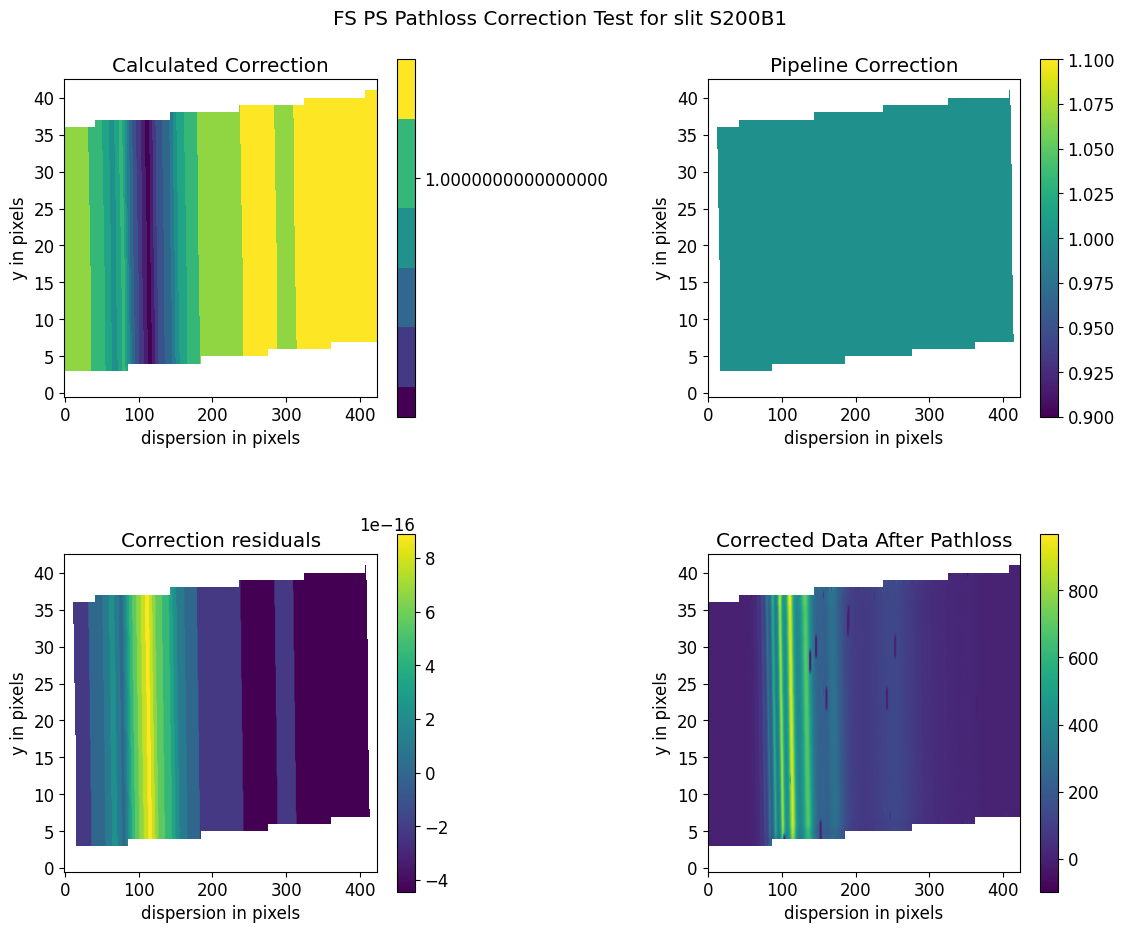

Calculating statistics... 

   Absolute Difference  :   mean = -1.143e-16    median = -2.220e-16    stdev = 3.639e-16
    Maximum   AbsoluteDifference = 8.882e-16
    Minimum   AbsoluteDifference = -4.441e-16
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED


 *** Final pathloss test result reported as PASSED *** 

('* Script FS_PS.py took ', '47.326223611831665 seconds to finish.')
Did pathloss validation test passed?  All slits PASSED path_loss test. 




<Figure size 640x480 with 0 Axes>

In [7]:
# Set common NPTT switches for this test

# accepted threshold difference with respect to benchmark files
threshold_diff = 9.999e-05

# other NPTT variables
writefile = False
show_figs = True
save_figs = False

# Get the data
detectors = ['nrs1', 'nrs2']
results_dict = {}
for mode_config, data_set_dict in testing_data.items():
    for det in detectors:
        print('Testing files for detector: ', det)
        data = get_artifactory_file(data_set_dict, det)
        uncal_file, msa_shutter_config = data
        print('Working with uncal_file: ', uncal_file)
        uncal_basename = os.path.basename(uncal_file)
        
        # Run the stage 1 pipeline 
        rate_object = Detector1Pipeline.call(uncal_file)
        # Make sure the MSA shutter configuration file is set up correctly
        rate_object.meta.instrument.msa_metadata_file = msa_shutter_config
        if msa_shutter_config is not None:
            rate_object.meta.instrument.msa_metadata_file = msa_shutter_config
            print('MSA shutter configuration file: ', rate_object.meta.instrument.msa_metadata_file)

        # Run the stage 2 pipeline steps
        try:
            pipe_object = AssignWcsStep.call(rate_object)
            skip_file = False
        except:
            print('An error occurred that made the pipeline crash, probably: No open slits fall on detector ', det)
            print("Skipping test for this file. \n")
            skip_file = True
            
        if not skip_file:                        
            if 'ifu' in uncal_basename.lower() or 'mos' in uncal_basename.lower():
                pipe_object = MSAFlagOpenStep.call(pipe_object)
            if 'ifu' not in uncal_basename.lower():
                pipe_object = Extract2dStep.call(pipe_object)
            pipe_object = SourceTypeStep.call(pipe_object)
            pipe_object = WavecorrStep.call(pipe_object)
            flat_field_object = FlatFieldStep.call(pipe_object)
            pathloss_object = PathLossStep.call(flat_field_object)

            # get the corresponding reference file from the pathloss datamodel
            reffile_path = pathloss_object.meta.ref_file.pathloss.name.replace("crds://", 
                                                    "https://jwst-crds.stsci.edu/unchecked_get/references/jwst/")

            # Run the validation test
            %matplotlib inline

            if 'fs' in uncal_file.lower():
                print('Running test for FS...')
                
                source_type = pathloss_object.meta.target.source_type
                
                if source_type == 'POINT' or source_type is None:
                    median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_fs_ps.pathtest(
                                                                                         flat_field_object, 
                                                                                         reffile_path,
                                                                                         pathloss_object,
                                                                                         writefile=writefile,
                                                                                         show_figs=show_figs,
                                                                                         save_figs=save_figs,
                                                                                         threshold_diff=threshold_diff)
                else:
                    median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_fs_uni.pathtest(
                                                                                         flat_field_object, 
                                                                                         reffile_path,
                                                                                         pathloss_object,
                                                                                         writefile=writefile, 
                                                                                         show_figs=show_figs,
                                                                                         save_figs=save_figs,
                                                                                         threshold_diff=threshold_diff)

            if 'mos' in uncal_file.lower():
                print('Running test for MOS...')
                median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_mos.pathtest(
                                                                                     flat_field_object, 
                                                                                     reffile_path,
                                                                                     pathloss_object,
                                                                                     writefile=writefile,
                                                                                     show_figs=show_figs,
                                                                                     save_figs=save_figs,
                                                                                     threshold_diff=threshold_diff)

            if 'ifu' in uncal_file.lower():
                print('Running test for IFU...')

                if pathloss_object.meta.target.source_type == 'POINT':
                    median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_ifu_ps.pathtest(
                                                                                         flat_field_object, 
                                                                                         reffile_path,
                                                                                         pathloss_object,
                                                                                         writefile=writefile,
                                                                                         show_figs=show_figs,
                                                                                         save_figs=save_figs,
                                                                                         threshold_diff=threshold_diff)
                else:
                    median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_ifu_uni.pathtest(
                                                                                         flat_field_object, 
                                                                                         reffile_path,
                                                                                         pathloss_object,
                                                                                         writefile=writefile, 
                                                                                         show_figs=show_figs,
                                                                                         save_figs=save_figs,
                                                                                         threshold_diff=threshold_diff)

        else:
            result_msg = 'skipped'

        # Did the test passed 
        print("Did pathloss validation test passed? ", result_msg, "\n\n")
        rd = {uncal_basename: result_msg}
        results_dict.update(rd)
        
        # close all open files
        psutil.Process().open_files()
        closing_files = []
        for fd in psutil.Process().open_files():
            if data_dir.name in fd.path:
                closing_files.append(fd)
        for fd in closing_files:
            try:
                print('Closing file: ', fd)
                open(fd.fd).close()
            except:
                print('File already closed: ', fd)


In [8]:
# Quickly see if the test passed 

print('These are the final results of the tests: ')
for key, val in results_dict.items():
    if not isinstance(val, str):
        if val:
            val = 'PASSED'
        else:
            val = 'FAILED'
    print('{:<42} {:<8}'.format(key, val))


These are the final results of the tests: 
fs_prism_nrs1_uncal.fits                   All slits PASSED path_loss test.
fs_prism_nrs2_uncal.fits                   All slits PASSED path_loss test.


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/sre_parse.py:501: ResourceWarning: unclosed file <_io.BufferedReader name='/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/.astropy/cache/download/url/aa0c667e23a747249d9442a76121955c/contents'>
  sourcematch = source.match


<a id="about_ID"></a>
## About this Notebook
**Author:** Maria A. Pena-Guerrero, Sr. Science Software Engineer, NIRSpec
<br>**Updated On:** Sep/26/2022

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 